## Waveform classification by RNN

In [1]:
import math
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from helper import DemoGenerator, myplot

rng = np.random.RandomState(1234)
random_state = 42

In [2]:
def orthogonal_initializer(shape, scale = 1.0):
    a = np.random.normal(0.0, 1.0, shape).astype(np.float32)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == shape else v
    return scale * q

class RNN:
    def __init__(self, in_dim, hid_dim, m):
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        # Xavier initializer
        self.W_in = tf.Variable(rng.uniform(
            low=-np.sqrt(6/(in_dim + hid_dim)),
            high=np.sqrt(6/(in_dim + hid_dim)),
            size=(in_dim, hid_dim)
        ).astype('float32'), name='W_in')
        # Random orthogonal initializer
        self.W_re = tf.Variable(orthogonal_initializer((hid_dim, hid_dim)), name='W_re')
        self.b_re = tf.Variable(tf.zeros([hid_dim], dtype=tf.float32), name='b_re')
        self.m = m

    def f_prop(self, x):
        def fn(h_tm1, x_and_m):
            x = x_and_m[0]  # [batch_size, in_dim]
            m = x_and_m[1] # [batch_size]
            h_t = tf.nn.tanh(tf.matmul(h_tm1, self.W_re) + tf.matmul(x, self.W_in) + self.b_re)  #[batch_size, hid_dim]
            return m[:, None] * h_t + (1 - m[:, None]) * h_tm1 # Mask

        _x = tf.transpose(x, perm=[1, 0, 2])  # [batch_size, seq_length, in_dim] -> [seq_length, batch_size, in_dim]
        _m = tf.transpose(self.m)  # [batch_size, seq_length] -> [seq_length, batch_size]
        h_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim])) # ([batch_size, in_dim], [in_dim, hid_dim]) -> [batch_size, hid_dim]
        _h = tf.scan(fn=fn, elems=[_x, _m], initializer=h_0) 
        h = tf.transpose(_h, perm=[1, 0, 2])  # [seq_length, batch_size, hid_dim] -> [batch_size, seq_length, hid_dim]
        return h
    
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
            low=-np.sqrt(6/(in_dim + out_dim)),
            high=np.sqrt(6/(in_dim + out_dim)),
            size=(in_dim, out_dim)
        ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        # ([batch_size, seq_length, hid_dim], [hid_dim, out_dim]) -> [batch_size, seq_length, out_dim]
        return self.function(tf.einsum('ijk,kl->ijl', x, self.W) + self.b) 

In [3]:
def f_props(layers, x):
    for i, layer in enumerate(layers):
        x = layer.f_prop(x)
    return x

In [3]:
in_dim = 1
hid_dim = 30
out_dim = 3 # 3-classes classification

x = tf.placeholder(tf.float32, [None, None, in_dim], name='x') # [batch_size, sequence_length, in_dim] 
m = tf.placeholder(tf.float32, [None, None]) # [batch_size, sequence_length 
t = tf.placeholder(tf.float32, [None, None, out_dim], name='t') # [batch_size, sequence_length, out_dim] 

layers = [
    RNN(in_dim, hid_dim, m=m),
    Dense(hid_dim, out_dim, tf.nn.softmax)
]

In [4]:
y1 = layers[0].f_prop(x)
y2 = layers[1].f_prop(y1)
y = y2

In [5]:
#y = f_props(layers, x)
cost = -tf.reduce_mean(tf.reduce_sum(t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)), axis=2) * m) #WARN: need to mask padding
train = tf.train.AdamOptimizer().minimize(cost)

In [6]:
def padding(x_lst, y_lst):
    """
    :ret train_X:[batch_size, seq_length, in_dim], train_Y:[batch_size, seq_length, out_dim]
    train_X will be padded with float('inf')
    """
    
    size = len(x_lst)
    max_len = 0
    for x in x_lst:
        max_len = max(max_len, len(x))
    
    train_X = np.ones((len(x_lst), max_len, 1)) * float('inf')
    train_Y = np.zeros((len(y_lst), max_len, 3))
    for idx in range(size):
        x = x_lst[idx]
        y = y_lst[idx]
        train_X[idx,:len(x),0] = x
        for ctg in (0, 1):
            msk = np.zeros(max_len).astype('bool')
            msk[:len(y)] = (y == ctg)
            train_Y[idx, msk, ctg] = np.ones(msk.sum())
    
    return train_X, train_Y

def mask(train_X):
    m = (train_X != float('inf')).all(axis = 2) #[batch_size, seq_length]
    return m

In [29]:
dg = DemoGenerator()
x_lst, y_lst = dg.generate(size=50)
train_X, train_Y = padding(x_lst, y_lst)
train_X = train_X[:, :500, :]　#WARN: back propagation with mask has problem
train_Y = train_Y[:, :500, :]
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)
train_m = mask(train_X)
valid_m = mask(valid_X)

In [31]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
train_X.shape

In [18]:
train_y1, train_y2 = sess.run([y1, y2], feed_dict={x: train_X, m: train_m,t: train_Y})
#_, train_cost = sess.run([train, cost], feed_dict={x: train_X, m: train_m,t: train_Y})

In [28]:
sess.run(m, feed_dict={m:train_m})

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.]], dtype=float32)

In [33]:
n_epochs = 1000
for epoch in range(n_epochs):
    _, train_cost = sess.run([train, cost], feed_dict={x: train_X, m: train_m,t: train_Y})
    if epoch % 100 == 0:
        pred, valid_cost = sess.run([y, cost], feed_dict={x: valid_X, m: valid_m,t: valid_Y})
        print('\tEPOCH: {}, Training cost: {}, Validation cost: {}'.format(epoch, train_cost, valid_cost))

	EPOCH: 0, Training cost: 0.21950797736644745, Validation cost: 0.21146160364151
	EPOCH: 100, Training cost: 0.1857062429189682, Validation cost: 0.18912462890148163
	EPOCH: 200, Training cost: 0.17594267427921295, Validation cost: 0.17668087780475616
	EPOCH: 300, Training cost: 0.14313696324825287, Validation cost: 0.1539650708436966
	EPOCH: 400, Training cost: 0.1479349285364151, Validation cost: 0.15116314589977264
	EPOCH: 500, Training cost: 0.12639601528644562, Validation cost: 0.13206622004508972
	EPOCH: 600, Training cost: 0.11450868844985962, Validation cost: 0.1249816045165062
	EPOCH: 700, Training cost: 0.10540131479501724, Validation cost: 0.12096139788627625
	EPOCH: 800, Training cost: 0.11567278951406479, Validation cost: 0.12260673940181732
	EPOCH: 900, Training cost: 0.10516397655010223, Validation cost: 0.11612257361412048


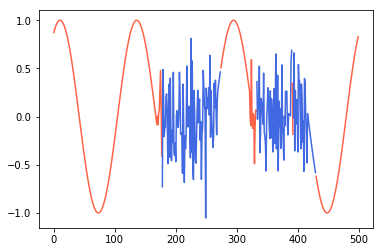

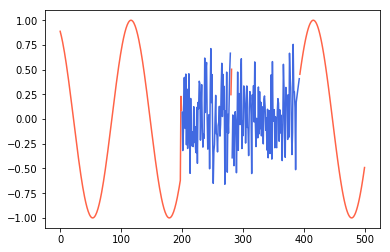

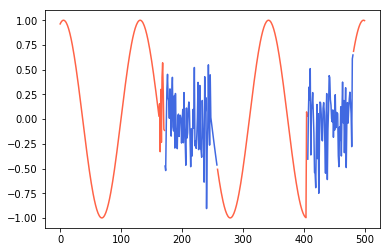

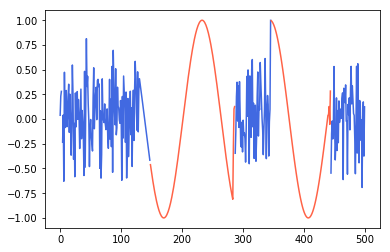

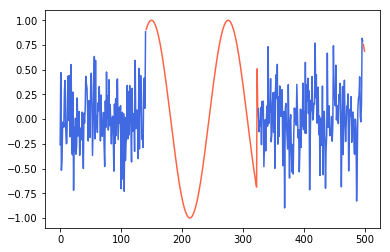

In [49]:
for idx in range(5):
    myplot(valid_X[idx],  pred[idx].argmax(axis=1))

In [43]:
len(pred[0].argmax(axis=1)[:len(x_lst[0])])

500

In [ ]:
plt.figure(figsize=(8,8))
for i in range(3):
    idx = 6
    plt.plot(np.arange(500), pred[idx][:, 0], 'r')
    plt.plot(np.arange(500), pred[idx][:, 1], 'g')
    plt.plot(np.arange(500), pred[idx][:, 2], 'b')

In [ ]:
train_Y[0]

In [ ]:
valid_m = np.ones((valid_X.shape[0], 500))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(np.arange(100), demo(100))